In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np, pandas as pd

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")


%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import NullFormatter
import matplotlib
from matplotlib.colors import LogNorm
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)

import seaborn as sns
rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 12,
    'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(font="serif",style="white",rc=rc)

# Running selection function

In [3]:
folder = '/home/andy/Documents/Research/SF/SFdata/Galaxia_data/'
iso_folder = '/home/andy/Documents/Research/SF/SFdata/'

In [4]:
sys.path.append('/home/andy/Documents/Research/SF/GitRepo/seestar/')
import StatisticalModels as sm

In [5]:
sys.path.append('/home/andy/Documents/Research/SF/GitRepo/seestar/')
import SelectionGrid, IsochroneScaling, StatisticalModels, SFInstanceClasses

## New selection functions

In [6]:
survey = pd.read_csv(folder + '/Galaxia_sf_survey.csv')
survey['Colour'] = survey.Japp-survey.Kapp

pointings = pd.read_csv(folder + '/Galaxia_sf_fieldinfo.csv')
pointings = pointings[['fieldID', 'glon', 'glat', 'halfangle','Magmin', 'Magmax', 'Colmin', 'Colmax']]
pointings.rename({'glon':'phi', 'glat':'theta'})

def get_photo(field):
    
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    return field_data

In [32]:
def get_spectro_flat(field):
    
    # Get photometric data
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    # Probability of inclusion
    p = np.zeros(field_data.shape[0]) + 0.1
    p[field_data[:,0]>13.5] = 0.
    p[field_data[:,1]<0.5] = 0.
    survive = np.random.rand(field_data.shape[0])<p
    
    return field_data[survive]

def get_spectro_tanh(field):
    
    # Get photometric data
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    # Probability of inclusion
    p = 0.5 * (1-np.tanh((field_data[:,0]-13.5+0.1)/np.exp(-3)))/2\
            * (1+np.tanh((field_data[:,1]-0.5)/np.exp(-2)))/2\
    
    return field_data

In [28]:
# Get photometric data
file_path = folder + '/photometric/'+str(2.0)+'.csv'
field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
field_data['Colour'] = field_data.Japp - field_data.Kapp
field_data = np.array(field_data[['Happ', 'Colour']])

In [31]:
field_data.shape[0]

8198

In [23]:
pointings = pointings[1:]
pointings.Magmin = 'NoLimit'
pointings.Magmax = 'NoLimit'
pointings.Colmin = 'NoLimit'

In [108]:
SF = SelectionGrid.SFGenerator(get_spectro_tanh, get_photo, pointings, 
                              spectro_model=('BGM_TNC', None), photo_model=('BGM_TNC', None))

The spectro model description is:('BGM_TNC', None)
The photo model description is:('BGM_TNC', None)


In [18]:
%%time
# Load in the isochrone interpolant
IsoCalculator = IsochroneScaling.IntrinsicToObservable()
IsoCalculator.LoadColMag(iso_folder+'isochrones/isochrone_interpolantinstances.pickle')

ImportError: No module named 'dill.dill'

## Generate new selection functions

In [109]:
%%time
SF.gen_obsSF(folder+'/Galaxia_obsSF.pickle')

Creating colour-magnitude field interpolants...
Finished col-mag calculation: 2.0, 1/2, Time: 0.00m, Left: 0.00mN stars =  8198
Running BGM
2   BIC:  -94621.10792551139    lnP:  47364.62383576208
3   BIC:  -96229.79399422313    lnP:  48196.00180662114
4   BIC:  -97916.35003120167    lnP:  49066.314761613605
5   BIC:  -98418.84947347795    lnP:  49344.59941925494
6   BIC:  -99120.56808654402    lnP:  49722.49366229117
7   BIC:  -99314.0944523269    lnP:  49846.2917816858
8   BIC:  -99513.49811195697    lnP:  49973.028548004026
9   BIC:  -99525.33937160912    lnP:  50005.984114333296
10   BIC:  -99675.39992282909    lnP:  50108.049326446475
11   BIC:  -99785.56117756115    lnP:  50190.1648903157
12   BIC:  -99778.77715436948    lnP:  50213.80781522306
13   BIC:  -99814.36862036485    lnP:  50258.63848472393
14   BIC:  -99768.53548102337    lnP:  50262.75685155638
15   BIC:  -99833.29194181807    lnP:  50322.17001845693
16   BIC:  -99795.27062831052    lnP:  50330.19429820635
17   BIC:  -

In [46]:
%time SF.debug_mode(3.0, part='sf')

N stars =  7964
Prior boundaries:  [[-6.24807333  1.21476959]
 [-2.93429657  3.15955058]]
False Linear search failed
2    BIC:  20501.38593825802    lnP:  -10196.796849137905
False Linear search failed
3    BIC:  21489.472784471815    lnP:  -10663.892212249251
True Converged (|f_n-f_(n-1)| ~= 0)
4    BIC:  17852.76460668166    lnP:  -8818.59006335862
False Linear search failed
5    BIC:  16415.209004390425    lnP:  -8072.864202217452
False Linear search failed
6    BIC:  16619.32045286311    lnP:  -8147.971866458242
True Converged (|f_n-f_(n-1)| ~= 0)
7    BIC:  16566.13020035491    lnP:  -8094.428680208589
True Converged (|f_n-f_(n-1)| ~= 0)
8    BIC:  16554.609229890615    lnP:  -8061.72013498089
True Converged (|f_n-f_(n-1)| ~= 0)
9    BIC:  16509.348619725595    lnP:  -8012.141769902827
True Converged (|f_n-f_(n-1)| ~= 0)
10    BIC:  16630.449423433245    lnP:  -8045.7441117611
True Converged (|f_n-f_(n-1)| ~= 0)
11    BIC:  16337.146940722352    lnP:  -7872.144810410101
True Conve

In [47]:
instsf = SF.obsSF[3.0].SF_model
instdf = SF.obsSF[3.0].DF_model
params_df = instsf.params_df

In [48]:
phot = pd.read_csv('/home/andy/Documents/Research/data/asfe2/Projects/sf_data/Galaxia_data/photometric/3.0.csv')
x = phot.Happ
y = phot.Japp-phot.Kapp
xs = (x-instsf.mux)/instsf.sx
ys = (y-instsf.muy)/instsf.sy

sf_params = instsf.params_f_scaled.copy()
pSelect = StatisticalModels.bivGaussMixture(sf_params, xs, ys)
uncut = (x<13.5)&(y>0.5)
len(instsf.x), np.sum(pSelect), np.sqrt(np.sum(pSelect)), np.sum(pSelect*uncut), np.sqrt(np.sum(pSelect*uncut))

(7964,
 7716.674828084882,
 87.84460614109942,
 1411.7717326854688,
 37.57355097253211)

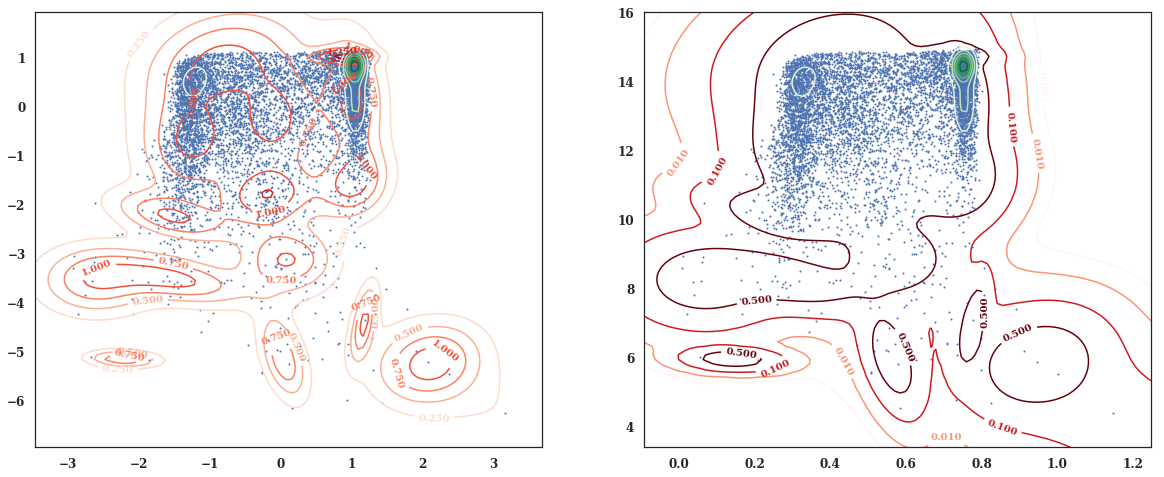

In [49]:
fig, axes = plt.subplots(1,2,figsize=(20,8))

plt.sca(axes[0])
plt.scatter(instsf.y_s, instsf.x_s, s=1)
x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f_scaled, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds')
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instsf.params_df, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()

plt.sca(axes[1])
plt.scatter(instsf.y, instsf.x, s=1)
x = np.linspace(instsf.rngy[0], instsf.rngy[1], 100)
y = np.linspace(instsf.rngx[0], instsf.rngx[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds', norm=LogNorm(), levels=(0.001, 0.01, 0.1, 0.5))
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instdf.params_f, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()

# Testing rootfinder

In [ ]:
%time SF.debug_mode(3.0, part='sf')

In [57]:
i= 5

In [ ]:
instsf = SF.obsSF[3.0].SF_model
instdf = SF.obsSF[3.0].DF_model
params_df = instsf.params_df

In [61]:
StatisticalModels.NIW_prior_params(instsf.prior_sfBounds)

Xdf = StatisticalModels.feature_scaling(instsf.photoDF.x, instsf.photoDF.y, instsf.mux, instsf.muy, instsf.sx, instsf.sy)
Xdf = np.vstack((Xdf[0], Xdf[1])).T

Xsf = np.vstack((instsf.x_s, instsf.y_s)).T

weights = 1/StatisticalModels.bivGaussMixture(instsf.params_df, instsf.x_s, instsf.y_s)
# K-Means clustering of initialisation
#print(Xsf.shape, Xdf.shape)
params=StatisticalModels.kmeans_init(Xsf, Xdf, i, weights=weights)
#print(params)
params_kms_pilogit=StatisticalModels.transform_sfparams_invlogit(params)

params_i = params_kms_pilogit

In [69]:
%%time
opt = scipy.optimize.minimize(StatisticalModels.calc_nlnP_grad_pilogit_NIW,  params_i,
                              args=(Xsf, priorParams, instsf.params_df), method='TNC',
                              jac=True, options={'maxiter':1000}, tol=1e-5)
print(opt)

     fun: 7995.812336641861
     jac: array([-3.92787498e+01,  1.16340865e+00, -2.85410454e+01,  3.50029175e+01,
        4.08246101e+00, -2.00438211e+00, -3.98897313e+01, -3.77415243e+01,
       -7.96483685e+00, -5.01617800e+01,  2.11467761e+00, -5.45118233e-02,
       -2.08554327e+01, -1.18437631e+01, -6.00037082e+01, -2.29462719e+01,
       -3.67665647e+00, -5.28515142e-02,  3.99043638e+01, -4.85462628e+01,
        1.05755989e+02,  4.12129452e+01,  2.90557137e+01, -8.38838564e+01,
        2.73288030e-01,  7.20765292e-02,  1.40293041e+02, -3.01622221e+01,
        5.75364684e-01,  1.10587973e-34])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 448
     nit: 22
  status: 1
 success: True
       x: array([-2.49448083,  0.51131076,  2.98630009,  1.92585798,  1.31729463,
        3.83140875, -1.00999406, -1.26089121,  3.21011589,  1.76974168,
        0.92219407,  6.59714524, -5.43434386,  1.67177951,  0.24979731,
        0.61112779, -2.98709079,  4.73400908,  1.02114496,  0.43216196,


In [86]:
%%time
opt = scipy.optimize.minimize(StatisticalModels.calc_nlnP_grad_pilogit_NIW,  params_i,
                              args=(Xsf, priorParams, instsf.params_df), method='TNC',
                              jac=True, options={'maxiter':1000}, tol=1e-5)
print(opt)

/home/andy/Documents/Research/SF/GitRepo/seestar/StatisticalModels.py:2287: RuntimeWarning: invalid value encountered in sqrt
  norm = 1/np.sqrt( ((2*np.pi)**2) * det_cov)


     fun: 9810.871580783041
     jac: array([-3.17259654e+02, -1.92576683e+02,  8.07278686e+01,  1.35363197e+02,
       -1.88267894e+02, -1.00370512e+03, -1.41340449e+03, -5.31889946e+02,
       -5.92669088e+01,  7.58550161e+01, -3.94959356e+02, -4.74064414e+02,
       -1.22504464e+01, -6.93181224e+00, -3.85514029e+03, -3.20550073e+03,
       -3.94209991e+01, -4.05448851e-02, -9.22815803e+01,  4.37245676e+01,
       -2.89486232e+01,  1.67967393e+01,  3.95777020e+01, -8.14611190e+01,
       -1.09166567e+02, -8.95285721e+01, -3.88061352e+01, -2.67558365e-01,
       -6.00869344e+01, -6.42092989e+01])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 158
     nit: 7
  status: 1
 success: True
       x: array([-0.68963083, -0.60738604,  1.69018793,  3.26197415, -0.41211391,
       -0.51198444,  0.21450681,  0.08796009,  0.42247454,  1.20777534,
       -0.24860324,  1.08929083, -6.21671085,  3.1429344 ,  0.87422431,
        1.04380861, -5.82469362,  4.59535736, -4.51829191,  0.60985857,
 

In [87]:
%time SF.debug_mode(3.0, part='sf')

N stars =  7964
Prior boundaries:  [[-6.24807333  1.21476959]
 [-2.93429657  3.15955058]]
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
False Linear search failed
2    BIC:  20501.38593825802    lnP:  -10196.796849137905
False Linear search failed
3    BIC:  21489.47278588025    lnP:  -10663.89221295347
False Linear search failed
4    BIC:  16672.733983114333    lnP:  -8228.574751574957
True Converged (|f_n-f_(n-1)| ~= 0)
5    BIC:  19881.62075727088    lnP:  -9806.07007865768
True Converged (|f_n-f_(n-1)| ~= 0)
6    BIC:  16390.915424745133   

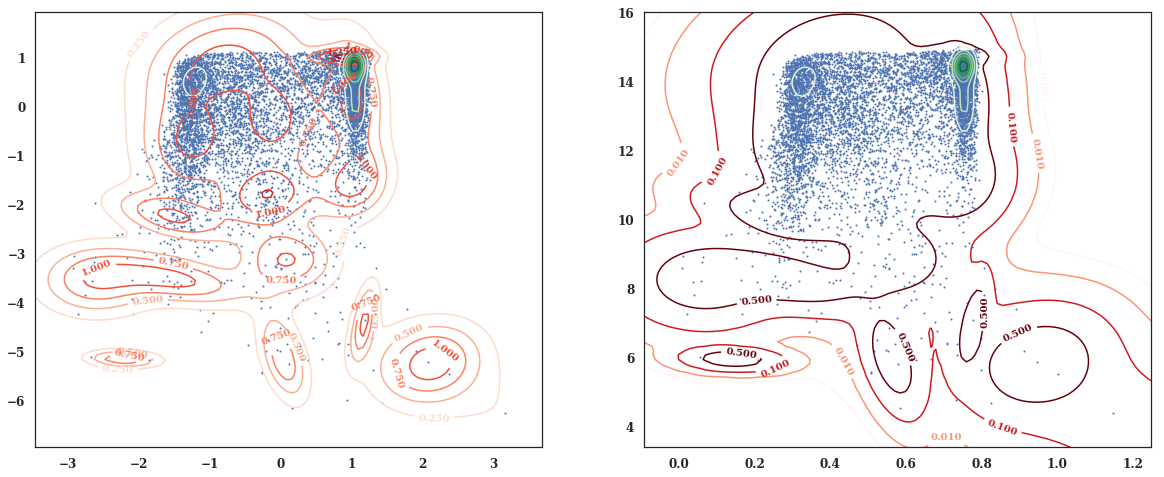

In [88]:
fig, axes = plt.subplots(1,2,figsize=(20,8))

plt.sca(axes[0])
plt.scatter(instsf.y_s, instsf.x_s, s=1)
x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f_scaled, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds')
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instsf.params_df, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()

plt.sca(axes[1])
plt.scatter(instsf.y, instsf.x, s=1)
x = np.linspace(instsf.rngy[0], instsf.rngy[1], 100)
y = np.linspace(instsf.rngx[0], instsf.rngx[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds', norm=LogNorm(), levels=(0.001, 0.01, 0.1, 0.5))
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instdf.params_f, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()

In [92]:
# Parameters - transform to means, covariances and weights
params = instsf.params_f_scaled.copy()
# means
# covariances
e_alpha = np.exp(-params[...,4])
p = 0.999/(1+e_alpha)
corr = np.sqrt(params[...,2]*params[...,3])*(2*p - 1)
S_sf = np.moveaxis(np.array([[params[...,2], corr], [corr, params[...,3]]]), -1, 0)
Sinv_sf, Sdet_sf = StatisticalModels.quick_invdet(S_sf)
#weights
# Logit correction of params[:,5] - [-inf, inf] --> [0, rt(det(2.pi.S))]
e_alpha_pi = np.exp(-params[...,5])
p_pi = 1./(1+e_alpha_pi)
pi = 2*np.pi*np.sqrt(Sdet_sf) * p_pi

# Unscaled parameters
params_original = params.copy()
params_original[:,4] = corr
params_original[:,5] = pi

In [104]:
# Parameters - transform to means, covariances and weights
params = instsf.params_f.copy()

corr = params[...,4]
cov = corr*np.sqrt(params[...,3]*params[...,2])
S_sf = np.moveaxis(np.array([[params[...,2], cov], [cov, params[...,3]]]), -1, 0)
Sinv_sf, Sdet_sf = StatisticalModels.quick_invdet(S_sf)
#weights
# Logit correction of params[:,5] - [-inf, inf] --> [0, rt(det(2.pi.S))]
pi = params[...,5]

# Unscaled parameters
params_original = params.copy()
params_original[:,4] = corr
params_original[:,5] = pi

In [ ]:
# Max SF prior
gmm_maxima = gradient_rootfinder(params_original, Sinv_sf, 1/(2*np.pi*np.sqrt(Sdet_sf)))
if gmm_maxima>1:
    return 1e100, params.flatten().copy()*0.#grad.flatten()

In [105]:
Sdet_sf

array([2.04311822e-02, 4.76484737e-03, 2.87710361e-03, 5.62519969e-05,
       2.16362576e-03, 1.55299795e-01, 2.08603110e-04, 3.14523919e-03,
       1.33644583e-04, 1.16678122e-02, 5.15966202e-03, 2.14917172e-03,
       1.24201331e-02, 2.72650062e-03, 5.21665589e-03, 1.04758384e-03])

In [106]:
StatisticalModels.gradient_rootfinder(instsf.params_f, Sinv_sf, 1/(2*np.pi*np.sqrt(Sdet_sf)))

1.6823966957884895

In [ ]:
params, Xsf, NIWprior, df_params, stdout=False

In [107]:
StatisticalModels.calc_nlnP_grad_pilogit_NIW(instsf.params_f_scaled, Xsf, priorParams, instsf.params_df)

(1e+100,
 array([ 0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,
        -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,
         0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,
         0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,
        -0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
         0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,
        -0., -0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0., -0.,
         0.,  0.,  0., -0.,  0.]))

In [ ]:
StatisticalModels.gradient_rootfinder(instsf.params_f, sigma_inv, norm)